In [1]:
# 0~3 right leg (up to down)
# 4~6 left leg (up to down)
# 7~10 body and head (down to up)
# 11~13 left hand (up to down)
# 14~16 right hand (up to down)

import os
import math
import shutil
import matplotlib
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

_CONNECTION = [
    [0, 1], [1, 2], [2, 3], [0, 4], [4, 5], [5, 6], [0, 7], [7, 8],
    [8, 9], [9, 10], [8, 11], [11, 12], [12, 13], [8, 14], [14, 15],
    [15, 16]]
# since fram 433 to frame 438 is missing ,so just skip them and turn aciton_1 into aciton_1 and aciton_2
# _ACTION_PROPOSALS = [[0 + 1, 321], [438+1, 651], [673 + 1, 982], [1003 + 1, 1313], [1335 + 1, 1643], [1664 + 1, 1973], [1995 + 1, 2304], [2327 + 1, 2639]]
_ACTION_PROPOSALS = [[0 + 1, 321], [342 + 1, 433], [438+1, 651],  [673 + 1, 982], [1003 + 1, 1313], [1335 + 1, 1643], [1664 + 1, 1973], [1995 + 1, 2304], [2327 + 1, 2639]]
_INDEX_RANGE = range(1, 2638 + 1)
_COLOR = [(0, 0, 0), (255, 0, 0), (0, 255, 0), (0, 0, 255),
          (0, 255, 255), (255, 0, 255), (0, 255, 255), (255, 255, 255)]

In [2]:
# This part is data processing: 
# 1. get all features 
# 2. prepare for the format for xgboost

def consine_formula(x, y, z):
    '''
    summary:
    using consine formula to calculate angle xyz
    input:
    x, y, z means the points, format: [int, int, int]
    output:
    the angle xyz, from 0 to 180
    '''
    xy2 = math.pow(x[0] - y[0], 2) + math.pow(x[1] - y[1], 2) + math.pow(x[2] - y[2], 2)
    yz2 = math.pow(y[0] - z[0], 2) + math.pow(y[1] - z[1], 2) + math.pow(y[2] - z[2], 2)
    xz2 = math.pow(x[0] - z[0], 2) + math.pow(x[1] - z[1], 2) + math.pow(x[2] - z[2], 2)
    return math.acos((xy2 + yz2 - xz2)/(2 * math.sqrt(xy2 * yz2))) * 180 / math.pi
# consine_formula([1, 0, 0], [0, 0, 0], [0, 0, 1])
# consine_formula([1, 0, 0], [0, 0, 0], [-1, 0, 1])

def action_index2action_label(i):
    '''
    summary: since the label of action is pretty wrong, so such map is necessary
    0: 0, 7
    1: 1 ,2, 5
    2: 3, 6
    3: 4, 8
    input: the original action_label
    output: updated action_label
    '''
    _DICT = {0: [0, 7], 1: [1, 2, 5], 2: [3, 6], 3: [4, 8]}
    for key in _DICT.keys():
        if i in _DICT[key]:
            return key
        
# for i in range(0, 8):
#     print(action_index2action_label(i))

def get_features_file():
    '''
    summary: get all the features from file
    feature1~6: relative pose of 15 - 9 and 16 - 9
    feature7: the angle of 14 15 16
    
    input: N/A
    output: two ndarray, which are required for xgboost
    
    update: since there is something wrong with simply conclude all frame in a period to a label, 
    so I created a label_Y.txt, which is write with np.savetxt and contains all valid label info
    result: codes to get all_Y is useless, just read a txt
    
    '''
    all_X = []
    all_Y = []
    for index, action_type in enumerate(_ACTION_PROPOSALS):        
        for file_index in range(action_type[0], action_type[1]):
#             np.append(all_Y, action_index2action_label(action_index))
            all_Y.append(action_index2action_label(index))
            _POINTS = np.loadtxt('./3dpose/{}.txt'.format(file_index))
            all_X.append([_POINTS[15][0] - _POINTS[9][0], _POINTS[15][1] - _POINTS[9][1],_POINTS[15][2] - _POINTS[9][2],
             _POINTS[16][0] - _POINTS[9][0], _POINTS[16][1] - _POINTS[9][1],_POINTS[16][2] - _POINTS[9][2], 
             consine_formula(_POINTS[14].tolist(), _POINTS[15].tolist(), _POINTS[16].tolist())])
            
    all_X = np.array(all_X)
#     all_Y = np.array(all_Y)
    all_Y = np.loadtxt('label_Y.txt')
    return all_X, all_Y
# get_features_file()

In [7]:
# This part is to use xgboost
all_X, all_Y = get_features_file()
sz = all_X.shape

train_X = all_X[:int(sz[0] * 0.5), :]
train_Y = all_Y[:int(sz[0] * 0.5)]

test_X = all_X[int(sz[0] * 0.5):, :]
test_Y = all_Y[int(sz[0] * 0.5):]

xg_train = xgb.DMatrix(train_X, label=train_Y)
xg_test = xgb.DMatrix(test_X, label=test_Y)

# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.3
param['max_depth'] = 4
# param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 5

print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

# watchlist = [(xg_train, 'train'), (xg_test, 'test')]
# num_round = 10
# bst = xgb.train(param, xg_train, num_round, watchlist)
# # get prediction
# pred = bst.predict(xg_test)
# print(pred[:100])
# print(test_Y[:100])
# error_rate = np.sum(pred != test_Y) / test_Y.shape[0]
# print('Test error using softmax = {}'.format(error_rate))

(1236, 7) (1236,) (1237, 7) (1237,)


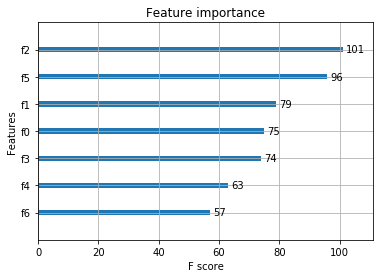

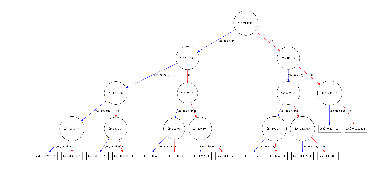

In [4]:
# This part is for understand this xgboost model
xgb.plot_importance(bst)
xgb.plot_tree(bst)
plt.show()

In [5]:
# This part is to do cross validation
dtrain = xgb.DMatrix(all_X, label=all_Y)
# print(dtrain.num_col(), dtrain.num_row())
param = {'max_depth':4, 'eta':0.3, 'silent':1, 'objective':'multi:softmax'}
param['num_class'] = 5
res = xgb.cv(param, dtrain, num_boost_round=10, nfold=5, seed=0, stratified=True, 
             callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                        xgb.callback.early_stop(3)])
print(res)

[0]	train-merror:0.247872	test-merror:0.292347
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 3 rounds.
[1]	train-merror:0.227557	test-merror:0.280236
[2]	train-merror:0.205213	test-merror:0.267275
[3]	train-merror:0.192375	test-merror:0.255547
[4]	train-merror:0.182673	test-merror:0.247031
[5]	train-merror:0.174585	test-merror:0.237339
[6]	train-merror:0.165893	test-merror:0.234518
[7]	train-merror:0.160131	test-merror:0.227235
[8]	train-merror:0.155682	test-merror:0.224003
[9]	train-merror:0.150627	test-merror:0.223201
   test-merror-mean  test-merror-std  train-merror-mean  train-merror-std
0          0.292347         0.018590           0.247872          0.012065
1          0.280236         0.017773           0.227557          0.004966
2          0.267275         0.019616           0.205213          0.005569
3          0.255547         0.015678           0.192375          0.005504
4          0.2

[ 4.  3.  4. ...,  4.  3.  4.]


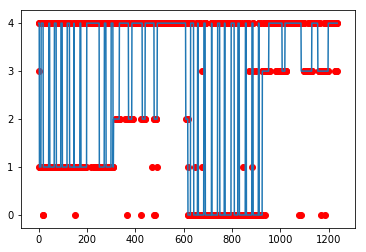

error num in each action: {4.0: 93, 1.0: 59, 2.0: 27, 0.0: 43, 3.0: 42}
total num for each action: {4.0: 599, 1.0: 198, 2.0: 72, 0.0: 242, 3.0: 126}
error rate for action_4.0: 0.15525876460767946
error rate for action_1.0: 0.29797979797979796
error rate for action_2.0: 0.375
error rate for action_0.0: 0.17768595041322313
error rate for action_3.0: 0.3333333333333333


In [6]:
# This part is to ckeck the error rate of each action
print(bst.predict(xg_test))
fig = plt.figure()
ax = fig.gca()

ax.plot(test_Y)
ax.scatter([i for i in range(0, bst.predict(xg_test).shape[0])], bst.predict(xg_test).tolist(), c='red')
plt.show()
error_num = {}
total_num = {}
for i in range(0, len(bst.predict(xg_test).tolist())):
    if test_Y.tolist()[i] not in error_num:
        error_num[test_Y.tolist()[i]] = 0
        total_num[test_Y.tolist()[i]] = 0
    if bst.predict(xg_test).tolist()[i] != test_Y.tolist()[i]:
        error_num[test_Y.tolist()[i]] += 1
    total_num[test_Y.tolist()[i]] += 1
    
print('error num in each action: {}'.format(error_num))
print('total num for each action: {}'.format(total_num))
for key in error_num.keys():
    print('error rate for action_{}: {}'.format(key, error_num[key]/total_num[key]))

In [7]:
def show_figure_with_12_plot(show_list, len_of_each_plot):
    for i in range(0, 12):
        plt.close()
        fig = plt.figure()
        ax = fig.gca()
        ax.plot(show_list[len_of_each_plot * i :len_of_each_plot * (i + 1)])
        plt.show()
def left_softmax(result_list):
    '''
    summary: for point that is not equal to its left neighbor and not equal to its right neighbor,
    I forcefully turn the value of such point to that of its left neighbor
    input: (list) result of prediction
    output: (list) list after softmax
    '''
    result_list_len = len(result_list) - 1
    for i in range(1, result_list_len):
        if result_list[i] != result_list[i - 1] and result_list[i] != result_list[i + 1]:
#             print('sting point:{}; value: {}'.format(i, result_list[i]))
            result_list[i] = result_list[i - 1]
    return result_list
# show_figure_with_12_plot(bst.predict(xg_test).tolist(), 100)
def two_point_softmax(result_list):
    '''
    summary: for point that is not equal to its left neighbor and not equal to its right neighbor,
    I forcefully turn the value of such point to that of its left neighbor
    difference is that: this function check two points each time!
    input: (list) result of prediction
    output: (list) list after softmax
    '''
    result_list_len = len(result_list) - 2
    for i in range(2, result_list_len):
        if result_list[i] != result_list[i - 1] and result_list[i] != result_list[i - 2]:
            if result_list[i + 1] != result_list[i + 2] and result_list[i + 1] != result_list[i + 3]:
#             print('sting point:{}; value: {}'.format(i, result_list[i]))
                result_list[i], result_list[i + 1] = result_list[i - 1], result_list[i + 2]
                
    return result_list

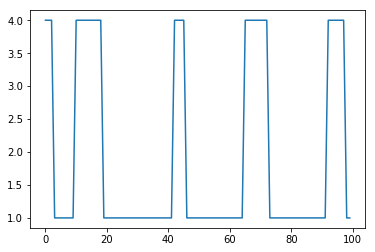

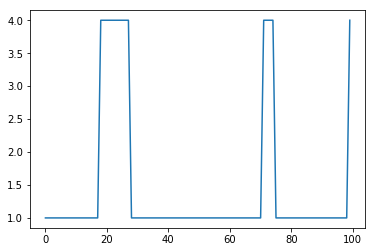

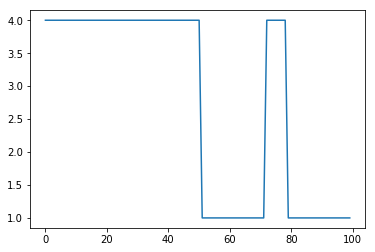

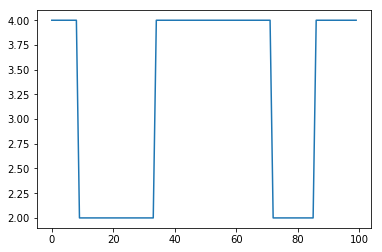

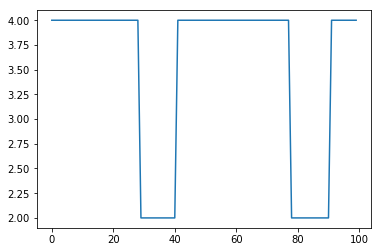

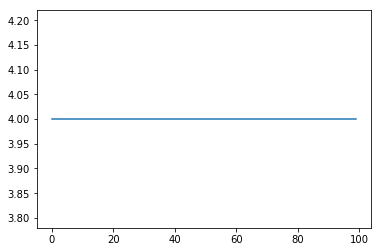

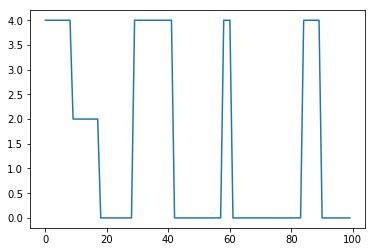

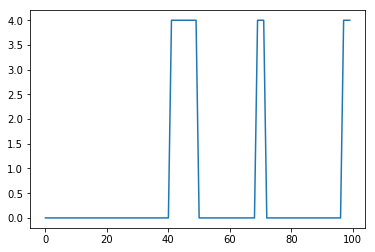

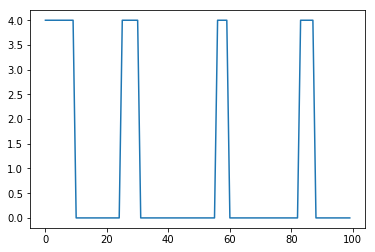

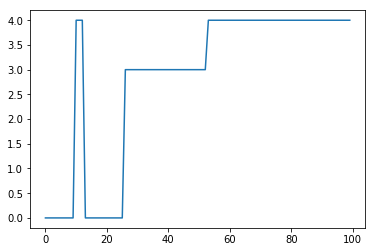

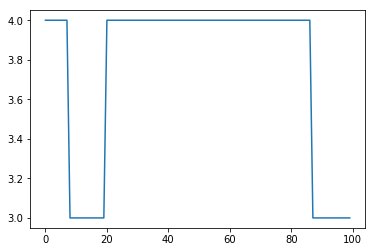

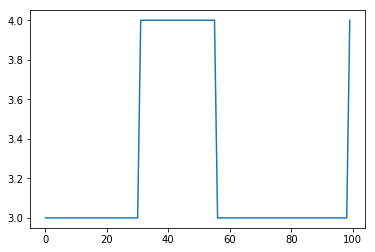

In [8]:
left_softmax(test_Y)
two_point_softmax(test_Y)
show_figure_with_12_plot(test_Y, 100)

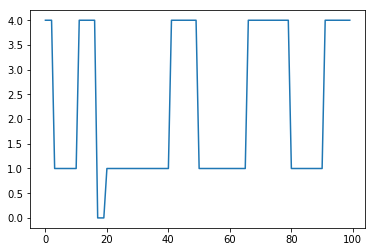

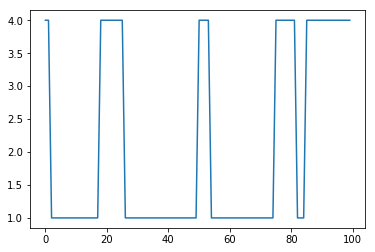

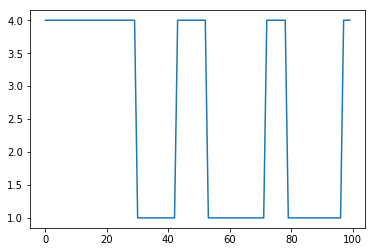

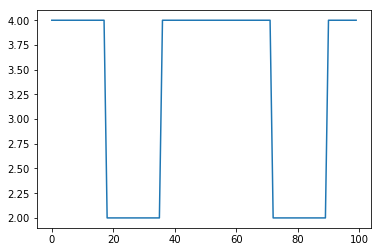

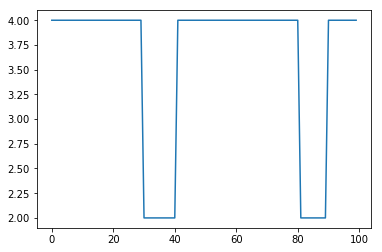

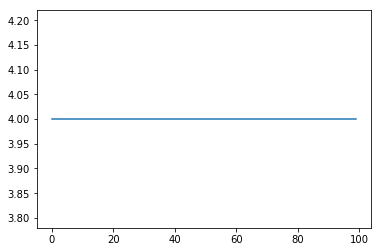

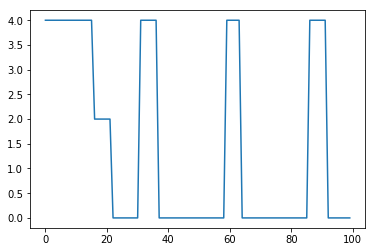

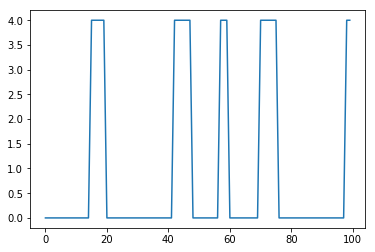

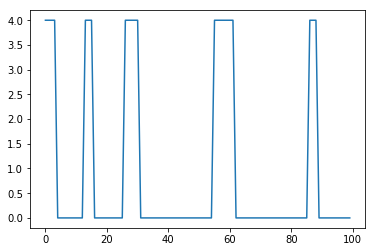

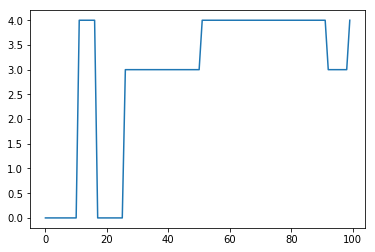

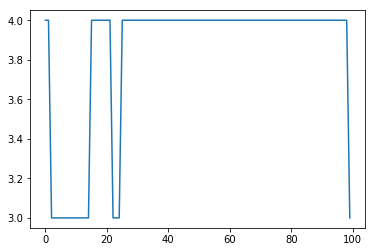

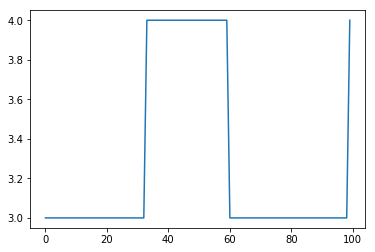

In [8]:
# This part is for softmax and show
result_list = bst.predict(xg_test).tolist()
result_list = left_softmax(result_list)
result_list = two_point_softmax(result_list)
show_figure_with_12_plot(result_list, 100)


In [10]:
# calculate error rate
count = 0
for i in range(len(test_Y)):
    if test_Y[i] != result_list[i]:
        count += 1
print(count / len(test_Y))
print(len(test_Y))
print(test_Y[0], test_Y[1236])

0.16168148746968472
1237
4.0 4.0


In [17]:
# This part is to get certain txt file
count = 0
for i in _ACTION_PROPOSALS:
    for file_index in range(i[0], i[1]):
        if count >= 1240:
            shutil.copy('3dpose/{}.txt'.format(file_index), 'selected_txt/{}.txt'.format(count - 1239))
        count += 1
#         t.append(start)
print(count)

2477


In [10]:
# this part is to write down images with context
from PIL import Image, ImageDraw, ImageFont
import random
font_type = ImageFont.truetype('SIMYOU.TTF', size=35)

# 总共分成8个时间段，对应8中动作
action_dict = {0:'正手拉球', 1:'反手拉球', 2:'反手发球', 3:'正手发球', 4:'无'}

start_point = 2476 - len(test_Y) + 1
end_point = 2476 + 1

# print(start_point, end_point)
for pic_index in range(start_point, end_point):
    im = Image.open('./original_imgs_without_connection/{}.png'.format(pic_index))
    context = ImageDraw.Draw(im)
    context.text(xy=(10, 350), text='正确动作: {0}'.format(action_dict[test_Y[pic_index - start_point]]), fill='black', font=font_type)
    context.text(xy=(10, 400), text='预测动作: {0}'.format(action_dict[result_list[pic_index - start_point]]), fill='blue', font=font_type)
    i = pic_index - start_point + 1
    im.save('./result_img_RGB/{0}.png'.format(i))

In [112]:
# for i in range(0, 12):
#     plt.close()
#     fig = plt.figure()
#     ax = fig.gca()
#     ax.plot(result_list[100 * i :100 * (i + 1)], c='red')
#     ax.plot(test_Y[100 * i :100 * (i + 1)], c='blue')
#     plt.savefig('./result_contract_1228/{}_{}.png'.format(i * 100, (i + 1) * 100))
#     plt.show()
plt.close()
fig = plt.figure()
ax = fig.gca()
ax.plot(result_list[1200 :], c='red')
ax.plot(test_Y[1200 :], c='blue')
plt.savefig('./result_contract_1228/{}_{}.png'.format(i * 100, 'end'))

In [46]:
# I have a try, that it's definitely easier to use numpy read the txt file directly, 
# instead of using file and list and clear the data
_POINTS = np.loadtxt('./3dpose/3.txt')
print(_POINTS)

t1 = np.array([_POINTS[15][0] - _POINTS[9][0], _POINTS[15][1] - _POINTS[9][1],_POINTS[15][2] - _POINTS[9][2],
             _POINTS[16][0] - _POINTS[9][0], _POINTS[16][1] - _POINTS[9][1],_POINTS[16][2] - _POINTS[9][2], 
             consine_formula(_POINTS[14].tolist(), _POINTS[15].tolist(), _POINTS[16].tolist())])
print(t1)

_POINTS = np.loadtxt('./3dpose/900.txt')
print(_POINTS)

t2 = np.array([_POINTS[15][0] - _POINTS[9][0], _POINTS[15][1] - _POINTS[9][1],_POINTS[15][2] - _POINTS[9][2],
             _POINTS[16][0] - _POINTS[9][0], _POINTS[16][1] - _POINTS[9][1],_POINTS[16][2] - _POINTS[9][2], 
             consine_formula(_POINTS[14].tolist(), _POINTS[15].tolist(), _POINTS[16].tolist())])
print(t2)
print('-------------------------------------------')

SUM = np.array([t1, t2])
print(SUM)


# d = {1:[3, 4], 2:[5,6]}
# for key in d.keys():
#     if 3 in d[key]:
#         print(1, d[key])
#     else:
#         print(0, d[key])

[[  41.74163057  109.00975723  -69.10039501]
 [-112.5619318   128.22255071  -41.82037771]
 [-204.12286513  -82.43183148 -400.5573336 ]
 [-274.37115597   -1.93991805 -795.73617224]
 [ 179.2525191    89.79695931  -37.06841385]
 [ 318.95434168 -114.88293622 -398.34221971]
 [ 416.22253787   25.6375709  -787.94436353]
 [  24.97286411  100.42363546  177.69632543]
 [ -27.0994537    24.45497278  392.33747555]
 [ -57.17515919  -79.85687244  479.92092702]
 [ -89.61358883  -50.7441307   683.33762333]
 [ 156.05927625    4.34964357  427.88978535]
 [ 342.01519927  -86.68835665  237.14531959]
 [ 189.19276267 -219.52531353  162.80249897]
 [-201.8593312    75.30094021  354.01606235]
 [-306.98466019  123.57139958   76.43136009]
 [-385.08365004  -45.59167441 -103.28216908]]
[-249.80950101  203.42827201 -403.48956693 -327.90849085   34.26519803
 -583.20309611  129.89518999]
[[ -35.09375192  -13.93279652 -109.72663975]
 [-189.98267472   50.06120168  -45.63660266]
 [-266.19957238 -126.99750997 -427.85863141

In [19]:
all_Y.shape

(2473,)